In [ ]:
import tensorflow as tf
import cv2
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import cv2
from glob import glob
from tqdm import tqdm
import skimage
from skimage.transform import resize
from sklearn.utils import shuffle
from skimage.color import rgb2gray
from tensorflow import keras
from keras import models
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Flatten


In [ ]:
image_data_location = "/content/drive/MyDrive/Dataset/Training and Validation"
test = "/content/drive/MyDrive/Dataset/Testing"

In [ ]:
X = []
y = []

In [ ]:


for fire_image_folder in os.listdir(image_data_location):
            if fire_image_folder in ["fire"]: 
                 fire_label = 0
            elif fire_image_folder in ["nofire"]:
                fire_label = 1
            else:
                fire_label = 2
            for image in tqdm(os.listdir(image_data_location +"/" +fire_image_folder+"/")):
                imgage_file = cv2.imread(image_data_location + "/" +fire_image_folder + "/" + image)
                if imgage_file is not None:
                    imgage_file = rgb2gray(skimage.transform.resize(imgage_file,(224,224,3), anti_aliasing=True))
                    imgage_array = np.asarray(imgage_file)
                    X.append(imgage_array)
                    y.append(fire_label)


100%|██████████| 760/760 [00:14<00:00, 53.05it/s]


In [ ]:
X = np.asarray(X)
y = np.asarray(y)

In [ ]:
X.shape

(1520, 224, 224)

In [ ]:
X, y = shuffle(X, y)

In [ ]:
y[:10]

[0, 0, 0, 0, 1, 1, 1, 0, 0, 1]

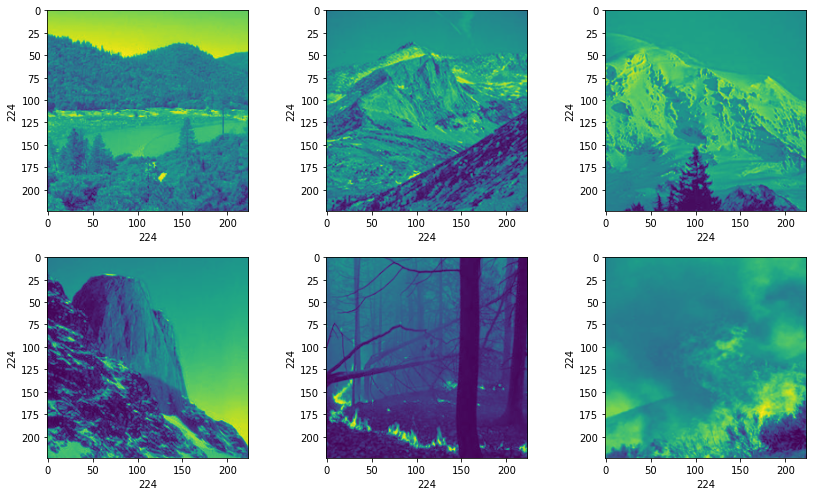

In [ ]:
plt.figure(figsize=(12,10))

for i in range(1,7):
  plt.subplot(3,3,i)
  plt.tight_layout()
  plt.imshow(X[i-1])
  plt.xlabel(X[i-1].shape[1], fontsize=10)
  plt.ylabel(X[i-1].shape[0], fontsize=10)

Text(0.5, 1.0, 'histogram representation of gray values')

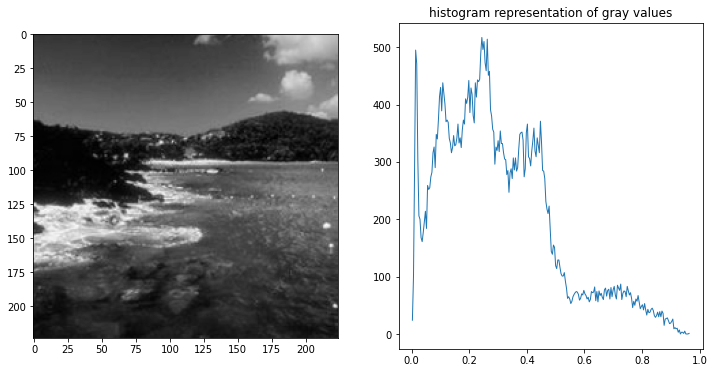

In [ ]:
from skimage.exposure import histogram
histogram, histogram_centers = histogram(X[10])
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(X[10], cmap=plt.cm.gray)
axes[1].plot(histogram_centers, histogram, lw=1)
axes[1].set_title('histogram representation of gray values')

In [ ]:
training_datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.15,
                                      rotation_range=0.1,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)


In [ ]:
train_generator = training_datagen.flow_from_directory(image_data_location,
                                                       target_size=(224,224),
                                                       shuffle = True,
                                                       class_mode='categorical',
                                                       batch_size = 28)

test_generator = test_datagen.flow_from_directory(test,
                                                              target_size=(224,224),
                                                              class_mode='categorical',
                                                              shuffle = True,
                                                              batch_size= 14)

Found 1520 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


In [ ]:
#Importing the inception model 
#Assigning shape of image
#leaving out last fully connected layers
input_tensor = Input(shape=(224, 224, 3))
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

In [ ]:

outputs = tf.keras.layers.Flatten()(base_model.output) #flattening to 1 dimension
outputs = Dense(1024, activation='relu')(outputs) #FCL with 1024 hidden units and relu activation
outputs = Dropout(0.2)(outputs) #20% dropout
predictions = Dense(2, activation='softmax')(outputs) #using softmax classifier
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_564 (Conv2D)            (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_564 (Batch  (None, 111, 111, 32  96         ['conv2d_564[0][0]']             
 Normalization)                 )                                                           

In [ ]:
#compiling model with stocastic gradient descent optimater at lr of 0.001
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), 
              loss=tf.losses.binary_crossentropy,
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = 14,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = 14)


Epoch 1/10
14/14 [==============================] - 15s 656ms/step - loss: 0.7977 - accuracy: 0.5780 - val_loss: 0.6074 - val_accuracy: 0.7704
Epoch 2/10
14/14 [==============================] - 8s 558ms/step - loss: 0.5837 - accuracy: 0.7832 - val_loss: 0.4981 - val_accuracy: 0.8520
Epoch 3/10
14/14 [==============================] - 8s 577ms/step - loss: 0.4886 - accuracy: 0.8138 - val_loss: 0.4123 - val_accuracy: 0.8776
Epoch 4/10
14/14 [==============================] - 8s 569ms/step - loss: 0.4403 - accuracy: 0.8520 - val_loss: 0.3673 - val_accuracy: 0.9184
Epoch 5/10
14/14 [==============================] - 8s 563ms/step - loss: 0.3605 - accuracy: 0.9031 - val_loss: 0.3319 - val_accuracy: 0.9031
Epoch 6/10
14/14 [==============================] - 8s 556ms/step - loss: 0.3429 - accuracy: 0.9107 - val_loss: 0.3200 - val_accuracy: 0.9133
Epoch 7/10
14/14 [==============================] - 8s 543ms/step - loss: 0.2860 - accuracy: 0.9301 - val_loss: 0.3119 - val_accuracy: 0.9082
Epoch

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


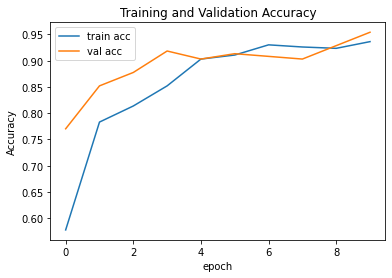

In [ ]:
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

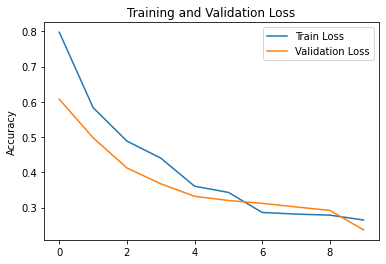

In [ ]:
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')

plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(val_acc)

[0.7704081535339355, 0.8520408272743225, 0.8775510191917419, 0.918367326259613, 0.9030612111091614, 0.9132652878761292, 0.9081632494926453, 0.9030612111091614, 0.9285714030265808, 0.954081654548645]


In [ ]:

fireimage= "/content/drive/MyDrive/ExtractedFire_Frames/fireclip555.jpg"
img = tf.keras.utils.load_img(
    fireimage, target_size=(224, 224)
)
